In [1]:
# Install dependencies
!pip install torch torchvision transformers peft bitsandbytes datasets opencv-python pillow --quiet

# Imports
from transformers import Blip2ForConditionalGeneration, Blip2Processor, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig
import torch
from PIL import Image
import requests

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load BLIP-2 with 4-bit quantization config for low memory usage
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)

model_name = "Salesforce/blip2-opt-2.7b"
processor = Blip2Processor.from_pretrained(model_name)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

# Apply LoRA for parameter-efficient fine-tuning
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]  # specific to OPT architecture in BLIP-2
)
model = get_peft_model(model, lora_config)

# Confirm trainable parameters
model.print_trainable_parameters()

# Move model to device (GPU/CPU)
model.to(device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 15.7 MB/s eta 0:00:00


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

trainable params: 2,621,440 || all params: 3,747,383,296 || trainable%: 0.0700
Question: Describe the scene.
Answer: Question: Describe the scene. Answer: The scene is a river with a small body of water in the middle of a grassy field


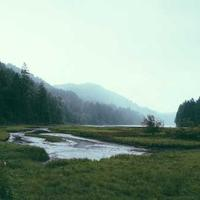

Question: Describe the scene.
Answer: Question: Describe the scene. Answer: The scene is a river with a small body of water in the middle of a grassy field


In [2]:
from IPython.display import display
# Demo: Load an example image and question
img_url = "https://fastly.picsum.photos/id/11/200/200.jpg?hmac=LBGO0uEpEmAVS8NeUXMqxcIdHGIcu0JiOb5DJr4mtUI"
image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
question = "Describe the scene."

# Preprocess inputs using BLIP-2 processor
prompt = f"Question: {question} Answer:"
inputs = processor(image, text=prompt, return_tensors="pt").to(device)

# Generate answer (inference)
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    answer = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

# Print results
display(image)
print("Question:", question)
print("Answer:", answer)

# Optional: Save LoRA adapters after fine-tuning (uncomment if applicable)
# model.save_pretrained("./lora_finetuned_blip2")


Upload an image file for VQA inference:


Saving download.jpeg to download.jpeg


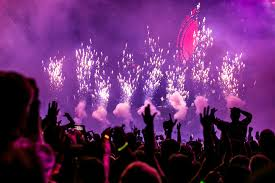

Enter your question about the image: what is happening 

Question: what is happening 
Answer: Question: what is happening  Answer: the crowd is watching a concert


In [5]:
from google.colab import files


print("Upload an image file for VQA inference:")
uploaded = files.upload()

# Load the uploaded image (take the first uploaded file)
image_path = next(iter(uploaded))
image = Image.open(image_path).convert("RGB")
display(image)

# Interactive question input
question = input("Enter your question about the image: ")
prompt = f"Question: {question} Answer:"

# Preprocess inputs and run inference
inputs = processor(image, text=prompt, return_tensors="pt").to(device)
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    answer = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

print("\nQuestion:", question)
print("Answer:", answer)

In [7]:
# Interactive question input
question = input("Enter your question about the image: ")
prompt = f"Question: {question} Answer:"

# Preprocess inputs and run inference
inputs = processor(image, text=prompt, return_tensors="pt").to(device)
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    answer = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

print("\nQuestion:", question)
print("Answer:", answer)

Enter your question about the image: how many  people are  there?

Question: how many  people are  there?
Answer: Question: how many  people are  there? Answer: there are many people in the crowd
